In [1]:
print("test")

test


In [2]:
import itertools
import tensorflow as tf
import pandas as pd
import numpy as np
import tqdm
import sys
# Local software setup
# sys.path.append('..')

from tensorflow.keras.models import load_model
from scipy.spatial.distance import euclidean

from src.losses import custom_loss
from src.metrics import point_in_ellipse
from src.metrics import point_in_ellipse_numpy
from src.metrics import circle_area
from src.data_utils import sample_vertices
from src.data_utils import read_vertex_file

RANDOM_SEED = 13

c:\users\egor\dubna\tracknet_v2\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\egor\dubna\tracknet_v2\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\egor\dubna\tracknet_v2\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\egor\dubna\tracknet_v2\venv\lib\site-packages\tensorflow\pyth

In [3]:
path_to_model = '../results/cloud__init-67-.val_point_in_ellipse.0.95.hdf5'
#path_to_model = "../data/models/tracknetv2_no_epoch100_eff9870_hits9967_loss2949_pie9863_area3.0235.h5"
#path_to_model = "../results_2019-08-28__22.34.56/result__init-21-.val_point_in_ellipse.0.94.hdf5"
custom_objects = {
    "_tracknet_loss": custom_loss,
    "point_in_ellipse": point_in_ellipse,
    "circle_area": circle_area}

model = load_model(path_to_model, custom_objects=custom_objects)

W0901 23:09:01.902702 13604 deprecation.py:506] From c:\users\egor\dubna\tracknet_v2\venv\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0901 23:09:01.904702 13604 deprecation.py:506] From c:\users\egor\dubna\tracknet_v2\venv\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0901 23:09:01.907703 13604 deprecation.py:506] From c:\users\egor\dubna\tracknet_v2\venv\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.i

## Load data

#### Train

In [4]:
from src.data_utils import read_train_dataset

In [6]:
train_data = read_train_dataset(
    "../data/train/", 
    vertex_fname='vertex.json', 
    random_seed=RANDOM_SEED,
    train_split=[-1, -1 ,-1, -1]
    )

Processing `../data/train\CC4GeVmb_100_n50k.tsv` file...

 Total tracks: [     0      0      0  22668  14614  14110 167942]
 Total broken tracks: [0, 0, 0, 5454, 4438, 3207, 4] 

Processing `../data/train\CC4GeVmb_101_n50k.tsv` file...

 Total tracks: [     0      0      0  22738  14877  14194 168267]
 Total broken tracks: [0, 0, 0, 5374, 4425, 3236, 4] 

Processing `../data/train\CC4GeVmb_102_n50k.tsv` file...



 27%|██▋       | 58513/220422 [00:19<01:13, 2214.57it/s]

KeyboardInterrupt: 

In [6]:
test_data = read_train_dataset(
    "../data/test/", 
    vertex_fname='vertex.json', 
    random_seed=RANDOM_SEED,
    train_split=[-1, -1 ,-1, -1]
    )

Processing `../data/test\CC4GeVmb_108_n50k.tsv` file...

 Total tracks: [     0      0      0  22422  14687  14590 168073]
 Total broken tracks: [0, 0, 0, 5405, 4354, 3311, 1] 

Processing `../data/test\CC4GeVmb_109_n50k.tsv` file...

 Total tracks: [     0      0      0  22457  14708  14321 167465]
 Total broken tracks: [0, 0, 0, 5367, 4403, 3298, 2] 

Processing `../data/test\CC4GeVmb_110_n50k.tsv` file...

 Total tracks: [     0      0      0  22746  14954  14314 167649]
 Total broken tracks: [0, 0, 0, 5470, 4451, 3328, 3] 

--[read_train_dataset] took 161.41 seconds to run.



100%|██████████| 219663/219663 [00:05<00:00, 43334.56it/s]


### Get buckets with tracks of different length

In [7]:
def get_tracklens(data):
    # nonzero rows
    nonzero = np.count_nonzero(data, axis=-1)
    return np.sum(nonzero > 0, axis=1)

In [8]:
train_tracklens = get_tracklens(train_data)
test_tracklens = get_tracklens(test_data)

In [9]:
ulen = np.unique(test_tracklens)
buckets = {x: np.where(test_tracklens==x)[0] for x in ulen}

print('Buckets for testing')
for k in buckets.keys():
    print(k, ':', len(buckets[k]))

Buckets for testing
4 : 51383
5 : 31141
6 : 33288
7 : 503181


## Calculate hit accuracy and efficiency for tracks with different length

In [10]:
from src.metrics import calc_metrics
from src.data_utils import get_part

### Fixed vertex

In [11]:
accs, hit_accs = [], []

print('Test on buckets')
for k in buckets.keys():
    print('Tracklen: %d' % k)
    acc, hit_acc = calc_metrics(
        test_data[buckets[k]], 
        model, 
        tracklen=k)
    print('\tBucket size: %d' % len(buckets[k]))
    print('\tAccuracy: %.4f' % acc)
    print('\tHit accuracy: %.4f' % hit_acc)
    accs.append(acc)
    hit_accs.append(hit_acc)

Test on buckets
Tracklen: 4
	Bucket size: 51383
	Accuracy: 0.8784
	Hit accuracy: 0.3756
Tracklen: 5
	Bucket size: 31141
	Accuracy: 0.8967
	Hit accuracy: 0.5792
Tracklen: 6
	Bucket size: 33288
	Accuracy: 0.8373
	Hit accuracy: 0.7666
Tracklen: 7
	Bucket size: 503181
	Accuracy: 0.9567
	Hit accuracy: 0.9913


### No vertex

In [12]:
accs, hit_accs = [], []

print('Test on buckets')
for k in buckets.keys():
    print('Tracklen: %d' % k)
    acc, hit_acc = calc_metrics(
        test_data[buckets[k]], 
        model, 
        tracklen=k)
    print('\tBucket size: %d' % len(buckets[k]))
    print('\tAccuracy: %.4f' % acc)
    print('\tHit accuracy: %.4f' % hit_acc)
    accs.append(acc)
    hit_accs.append(hit_acc)

Test on buckets
Tracklen: 3
	Bucket size: 67625
	Accuracy: 0.0102
	Hit accuracy: 0.0026
Tracklen: 4
	Bucket size: 44349
	Accuracy: 0.0039
	Hit accuracy: 0.0473
Tracklen: 5
	Bucket size: 43225
	Accuracy: 0.0000
	Hit accuracy: 0.1028
Tracklen: 6
	Bucket size: 503187
	Accuracy: 0.0000
	Hit accuracy: 0.3153


## Plot results

In [12]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### Fixed vertex

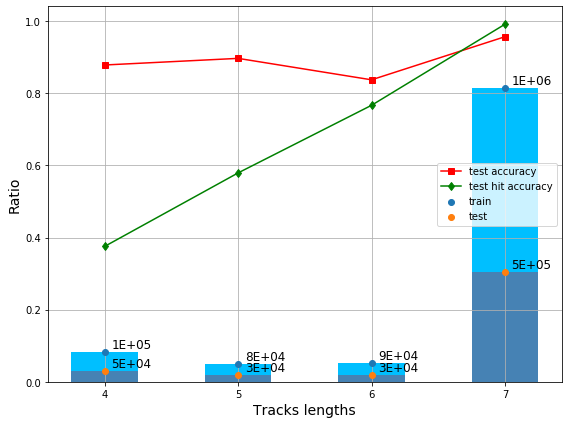

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

# tracks lengths
train_ulen, train_usize = np.unique(train_tracklens, return_counts=True)
test_ulen, test_usize = np.unique(test_tracklens, return_counts=True)

# normed sizes
normed_train_usize = train_usize / len(train_data)
normed_test_usize = test_usize / len(train_data)

# plot train
ax.bar(train_ulen, normed_train_usize, align='center', width=0.5, color='deepskyblue')
ax.scatter(train_ulen, normed_train_usize, zorder=10)
for x,y,s in zip(train_ulen, normed_train_usize, train_usize):
    ax.text(x+0.05, y+0.01, '%.E' % s, fontsize=12)
# plot test
ax.bar(test_ulen, normed_test_usize, align='center', width=0.5, color='steelblue')
ax.scatter(test_ulen, normed_test_usize, zorder=10)
for x,y,s in zip(test_ulen, normed_test_usize, test_usize):
    ax.text(x+0.05, y+0.01, '%.E' % s, fontsize=12)
# metrics
ax.plot(ulen, accs, marker='s', color='red')
ax.plot(ulen, hit_accs, marker='d', color='green')

# set up plot
ax.set_xticks(ulen)
plt.legend(['test accuracy', 'test hit accuracy', 'train', 'test'])
ax.set_xlabel('Tracks lengths', fontsize=14)
ax.set_ylabel('Ratio', fontsize=14)

plt.tight_layout()
plt.grid()

# save plot
plt.savefig('Metrics_fix_vertex.png', dpi=300)
plt.show()

### No vertex

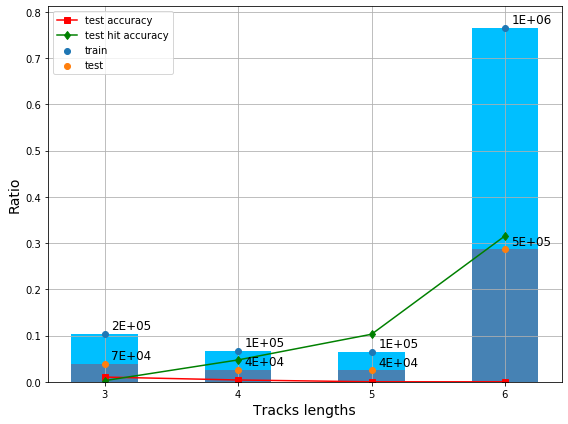

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

# tracks lengths
train_ulen, train_usize = np.unique(train_tracklens, return_counts=True)
test_ulen, test_usize = np.unique(test_tracklens, return_counts=True)

# normed sizes
normed_train_usize = train_usize / len(train_data)
normed_test_usize = test_usize / len(train_data)

# plot train
ax.bar(train_ulen, normed_train_usize, align='center', width=0.5, color='deepskyblue')
ax.scatter(train_ulen, normed_train_usize, zorder=10)
for x,y,s in zip(train_ulen, normed_train_usize, train_usize):
    ax.text(x+0.05, y+0.01, '%.E' % s, fontsize=12)
# plot test
ax.bar(test_ulen, normed_test_usize, align='center', width=0.5, color='steelblue')
ax.scatter(test_ulen, normed_test_usize, zorder=10)
for x,y,s in zip(test_ulen, normed_test_usize, test_usize):
    ax.text(x+0.05, y+0.01, '%.E' % s, fontsize=12)
# metrics
ax.plot(ulen, accs, marker='s', color='red')
ax.plot(ulen, hit_accs, marker='d', color='green')

# set up plot
ax.set_xticks(ulen)
plt.legend(['test accuracy', 'test hit accuracy', 'train', 'test'])
ax.set_xlabel('Tracks lengths', fontsize=14)
ax.set_ylabel('Ratio', fontsize=14)

plt.tight_layout()
plt.grid()

# save plot
plt.savefig('Metrics_no_vertex.png', dpi=300)
plt.show()